In [1]:
# <examples/doc_model_two_components.py>
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
from lmfit import Model
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel
from lib.to_precision import to_precision
import lmfit
from sympy import *
import sympy
from sympy.solvers import solve
from sympy import Symbol
import math
import datetime
from ipywidgets import interact, FloatText, IntText, fixed, Text
now = lambda: str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").split(".")[0]
import inspect
import pylandau 

In [2]:
# def get_Latex_Func(func):
#     # Get the source code of the function
#     source_lines = inspect.getsource(func).split('\n')

#     # Find the return statement
#     return_line = [line for line in source_lines if 'return' in line][0]

#     # Extract the expression after 'return'
#     expr = return_line.split('return')[1].strip()
    
#     tatex_func = sympy.latex(sympy.sympify(expr))
#     strg = (
#         "\\begin{align} \n \t f(x) = " + tatex_func + "\n" + "\end{align} \n"
#     )
#     return strg


def get_Latex_Func(func):
    # Get the source code of the function
    source_lines = inspect.getsource(func).split('\n')
    
    # Find the return statement
    return_line = [line for line in source_lines if 'return' in line][0].strip()
    
    # Extract the expression after 'return'
    expr = return_line.split('return')[1].strip()
    
    # Extract variable names from the function's signature
    
    sig = inspect.signature(func)
    param_names = list(sig.parameters.keys())
    
    # Create sympy symbols for all parameters
    symbols = sympy.symbols(' '.join(param_names))
    
    # Create a local dictionary of symbols
    local_dict = dict(zip(param_names, symbols))
    
    # Add numpy and math functions to the local dictionary
    local_dict.update({
        'sqrt': sympy.sqrt,
        'exp': sympy.exp,
        'pi': sympy.pi
    })
    
    # Convert the expression to a SymPy expression
    sympy_expr = sympy.parsing.sympy_parser.parse_expr(
        expr.replace('np.', '').replace('math.', ''), 
        local_dict=local_dict
    )
    
    # Convert to LaTeX
    tatex_func = sympy.latex(sympy_expr)
    
    strg = (
        "\\begin{align} \n \t f(" + ", ".join(param_names) + ") = " + tatex_func + "\n" + "\\end{align} \n"
    )
    return strg




def save_data_to_file(filename='data.pkl'):
    # Dictionary für Parameter-Werte erstellen
    data_dict = {"x":Daten.get_x(),"xerr":Daten.get_xerr(),"y":Daten.get_y(),"yerr":Daten.get_yerr(),"XName":Daten.get_XName(),"YName":Daten.get_YName()}
    # Konvertiere alle Numpy-Arrays im Dictionary in Listen
    # dict_serializable = {key: value.tolist() if isinstance(value, np.ndarray) else value 
    #                      for key, value in data_dict.items()}
    # __x = []
    # __y = []
    # __xerr = 0
    # __yerr = 0
    # __XName = "x"
    # __YName = "y"
    # __FileName = "dataset_1"

    # Parameter als JSON-Datei speichern
    with open(filename, 'wb') as f:
        pickle.dump(data_dict, f)
    print(f"Daten wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_data_from_file(filename='params.pkl'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f)
    
    # # Konvertiere Listen zurück in Numpy-Arrays
    # data_dict= {key: np.array(value) if isinstance(value, list) else value
    #                     for key, value in dict_with_arrays.items()}

    # Geladene Werte in die Parameter setzen
    Daten.set_x(data_dict.get("x"))
    Daten.set_xerr(data_dict.get("xerr"))
    Daten.set_y(data_dict.get("y"))
    Daten.set_yerr(data_dict.get("yerr"))
    Daten.set_XName(data_dict.get("XName"))
    Daten.set_YName(data_dict.get("YName"))

    print(f"Daten wurden aus {filename} geladen.")

def finish(x,y,result, string, y_err, yLabel, xLabel, var_func_bool= False):
    fig = plt.figure(figsize=(9,6), dpi=80)
    dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
    #plt.plot(x, y, 'skyblue')
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.errorbar(
        y = y, 
        x = x, 
        yerr = y_err,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    plt.legend(loc='best')

    plt.ylabel(yLabel, fontsize=20)
    plt.xlabel(xLabel, fontsize=20)

    plt.legend(fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Fit.pdf")
    plt.show()

    string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
        + "\t\\caption{"+str(string)+", Fit} \n \t\\label{fig:"+str(string)+", Fit} \n\end{figure}"
    print(string_fig)

    text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
    string_fig += "\n \\\\ \n" 
    string_fig += get_Latex_Func(Daten.get_func()) if var_func_bool else ""
    string_fig += table_of_params(result)
    text_file.write(string_fig)
    text_file.close()

def table_of_params(result_of_fit):
    sig_num = 3
    string = "" + (
        "\\begin{table}[ht] \n"
        "\centering \n") +"\caption{" + str(Daten.get_FileName()) +", Fit Parameter Tabelle} \n"  + (
        "\label{tab:my-table}\n"
        "\\begin{tabular}{|l|c|}\n" 
        "\hline\n"
        "Parameter Name\t&\tWert \\\\ \hline\n"
    )
    for i in result_of_fit.params:
        str_param_val = f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}" 
        str_param_std = f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}" 
        string += (
            str(i) + "\t&\t" +
            str_param_val +
            ("" if "." in str_param_val  else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num+2 -len(f"{float(result_of_fit.params[i].value): .{(len(str(math.floor(result_of_fit.params[i].value))) if math.floor(result_of_fit.params[i].value) != 0 else 0) +sig_num}}"))) +
            " \\pm "+ 
            str_param_std +
            ("" if "." in str_param_std else ".")+
            ("0"*((len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num+2-len(f"{float(result_of_fit.params[i].stderr): .{(len(str(math.floor(result_of_fit.params[i].stderr))) if math.floor(result_of_fit.params[i].stderr) != 0 else 0) +sig_num}}"))) +
            "\\\\ \hline\n"
        )
    string += (
        "\end{tabular} \n"
        "\end{table}"
    )
    return string


class Data:
    __x = []
    __y = []
    __xerr = 0
    __yerr = 0
    __XName = "x"
    __YName = "y"
    __FileName = "dataset_1",
    __Version = ""
    __pars = None
    __func = None
    
    def set_func(self, x):
        self.__func = x
        return
    def get_func(self):
        return self.__func

    def set_x(self, x):
        self.__x = x
        return  
    def set_y(self, x):
        self.__y = x
        return  
    def set_yerr(self, x):
        self.__yerr = x
        return  
    def set_xerr(self, x):
        self.__xerr = x
        return  
    
    def get_x(self):
        return self.__x
    def get_y(self):
        return self.__y
    def get_xerr(self):
        return self.__xerr
    def get_yerr(self):
        return self.__yerr
    
    def set_XName(self, x):
        self.__XName = rf"{x}"
        return
    def set_YName(self, x):
        self.__YName = rf"{x}"
        return
    def get_XName(self):
        return self.__XName
    def get_YName(self):
        return self.__YName
    
    def get_FileName(self):
        return self.__FileName
    
    def set_FileName(self, x):
        self.__FileName = f"{x}"
        return
    def set_Version(self, x):
        self.__Version = f"{x}"
        return
    def get_Version(self):
        return self.__Version
    
    def get_pars(self):
        return self.__pars
    def set_pars(self,x):
        self.__pars = x
        return

def import_Data(Datei:str="dataset_1", x_err_bool = False, y_err_bool = False, Daten=Data(), skip_lower:str="0", skip_upper:str="0", x_name:str="x", y_name:str="y", save_bool=False,Save:int=0,Load:int=0,switch_axes:bool=False,show_plot:bool=True):
    data = np.genfromtxt(Datei+".txt", skip_header = int(skip_upper), skip_footer = int(skip_lower))
    #data = np.genfromtxt(string+".txt", skip_header = 1, skip_footer = 18)

    if x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(data[:, 3])
    elif x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(data[:, 1])
        Daten.set_y(data[:, 2])
        Daten.set_yerr(0)
    elif not x_err_bool and y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(data[:, 2])
    elif not x_err_bool and not y_err_bool:
        Daten.set_x(data[:,0])
        Daten.set_xerr(0)
        Daten.set_y(data[:, 1])
        Daten.set_yerr(0)
    
    Daten.set_XName(x_name)
    Daten.set_YName(y_name)
    Daten.set_FileName(Datei)

    if switch_axes:
        temp = [Daten.get_x(), Daten.get_xerr()]
        Daten.set_x(Daten.get_y())
        Daten.set_xerr(Daten.get_yerr())
        Daten.set_y(temp[0])
        Daten.set_yerr(temp[1])
        
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_data_to_file(f'{Daten.get_FileName()}_daten_{Save}.pkl')
    if Load != 0:
        # Aufruf der Funktion zum Laden
        load_data_from_file(f'{Daten.get_FileName()}_daten_{Load}.pkl')

    if show_plot:
        plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
            fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
            label = r'Werte')
        plt.legend(loc='best')
        plt.ylabel(Daten.get_YName(), fontsize=20)
        plt.xlabel(Daten.get_XName(), fontsize=20)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        if save_bool:
            plt.savefig(Datei + f"_{Load}_Plot.pdf")
            string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Datei + "_Plot.pdf} \n" \
                + "\t\\caption{"+str(Datei)+", Plot_log} \n \t\\label{fig:"+str(Datei)+", Plot_log} \n\end{figure}"
            print(string_fig)

        plt.show()



# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

## Interactive

In [3]:
Daten = Data()

interact(import_Data, Datei="A4_V20_1.h5_charge", x_err_bool = False, y_err_bool = False, x_name = "Zeit [ns]", y_name = "Mittleres Signal (ADC)", Daten=fixed(Daten), 
         skip_lower = "0",
         skip_upper = "2",
         save_bool = False,
         switch_axes = False,
         Save=IntText(value=0,description='Daten Speichern:'), Load=IntText(value=0,description='Daten Laden:'),
         
         )# IntText(value=0, step=1)
print()

interactive(children=(Text(value='A4_V20_1.h5_charge', description='Datei'), Checkbox(value=False, description…

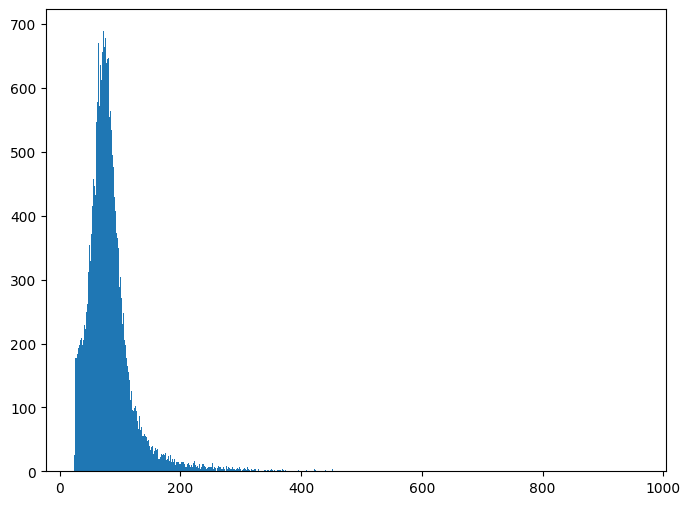

In [4]:
Daten = Data()
data = np.genfromtxt("A4_V20.h5_charge.txt", skip_header = int(0), skip_footer = int(0))
fig = plt.figure(figsize=(8, 6))
plt.hist(data,1000)
plt.show()

In [5]:
data = np.genfromtxt("A4_V20.h5_charge.txt", skip_header = int(0), skip_footer = int(0))

daten = np.histogram(data, bins=1000)
y = daten[0]
#y = [res for i in daten[1]]
x = np.zeros(y.shape)
for i, x_wert in enumerate(daten[1]):
    if i == 0:
        continue
    x_pre_wert = daten[1][i-1]
    x[i-1] = (x_wert + x_pre_wert)/2



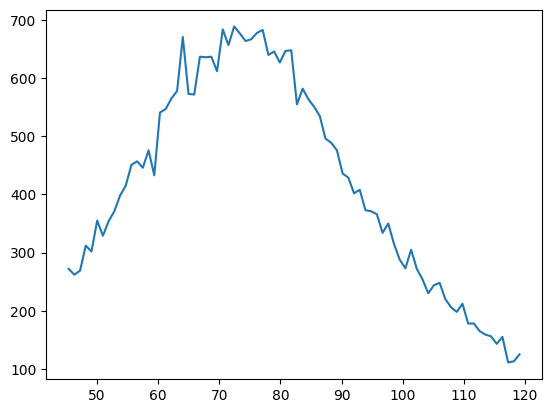

In [6]:
min, max = 15, 230
mask = (x > 45) & (x < 120)
plt.plot(x[mask],y[mask])

In [7]:
from lmfit.models import GaussianModel, Model

Datei_Name = "A4_V20.h5_charge.txt"
data = np.genfromtxt(Datei_Name, skip_header = int(0), skip_footer = int(0))

daten = np.histogram(data, bins=1000)
y = daten[0]
#y = [res for i in daten[1]]
x = np.zeros(y.shape)
for i, x_wert in enumerate(daten[1]):
    if i == 0:
        continue
    x_pre_wert = daten[1][i-1]
    x[i-1] = (x_wert + x_pre_wert)/2


Daten.set_XName(r"Ladung [AU]")
Daten.set_YName(r"Anzahl")
Daten.set_FileName(Datei_Name)
Daten.set_x(x)
Daten.set_xerr(0)
Daten.set_y(y)
Daten.set_yerr(0)

def land(x, mpv, eta, sigma, A):
        return pylandau.langau(x, mpv, eta, sigma, A)

mod = Model(land)
pars = mod.make_params()
pars

name,value,initial value,min,max,vary
mpv,-inf,None,-inf,inf,True
eta,-inf,None,-inf,inf,True
sigma,-inf,None,-inf,inf,True
A,-inf,None,-inf,inf,True


In [8]:
pars["mpv"].value = 23
pars["eta"].value = 25
pars["sigma"].value = 54
pars["A"].value = 1e+4
pars['A'].min = 70

# weights = 1/np.sqrt(Daten.get_y())
# weights[weights == np.inf] = 0
# Daten.set_yerr(weights)

result = mod.fit(Daten.get_y()[mask], pars, x=Daten.get_x()[mask])#, weights = weights
finish(Daten.get_x(),Daten.get_y(),result, Daten.get_FileName(), Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())
result

C:\Users\marie\AppData\Local\Temp\ipykernel_3740\3770530788.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return pylandau.langau(x, mpv, eta, sigma, A)


TypeError: 'int' object is not callable

<Figure size 720x480 with 0 Axes>

C:\Users\marie\AppData\Local\Temp\ipykernel_6592\444125498.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return A * pylandau.langau(x, mpv, eta, sigma)


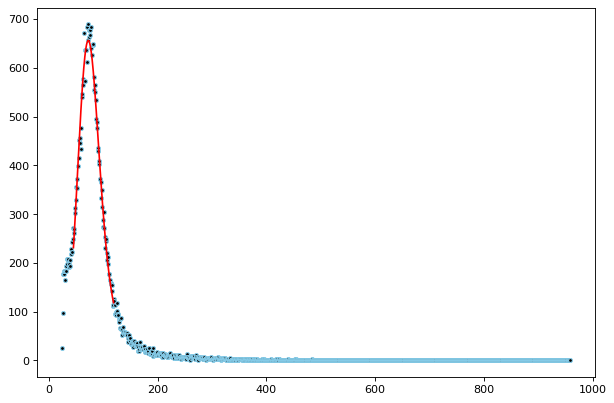

In [28]:
from lmfit.models import Model
import numpy as np
import pylandau

Datei_Name = "A4_V20.h5_charge.txt"
data = np.genfromtxt(Datei_Name, skip_header=0, skip_footer=0)
daten = np.histogram(data, bins=1000)
y = daten[0]

x = np.zeros(y.shape)
for i, x_wert in enumerate(daten[1]):
    if i == 0:
        continue
    x_pre_wert = daten[1][i-1]
    x[i-1] = (x_wert + x_pre_wert)/2
    
Daten.set_XName(r"Ladung [AU]")
Daten.set_YName(r"Anzahl")
Daten.set_FileName(Datei_Name)
Daten.set_x(x)
Daten.set_xerr(0)
Daten.set_y(y)
Daten.set_yerr(0)

# Mask definition
mask = (x > 45) & (x < 120)

# Validate mask has data
x_masked = x[mask]
y_masked = y[mask]

if len(x_masked) == 0:
    raise ValueError("Mask results in empty dataset")

def land(x, mpv, eta, sigma, A):
    try:
        return A * pylandau.langau(x, mpv, eta, sigma)
    except Exception as e:
        print(f"Error in Landau function: {e}")
        return np.zeros_like(x)

mod = Model(land)
pars = mod.make_params()

# More robust initial parameter estimation
pars['mpv'].value = np.median(x_masked)
pars['mpv'].min = np.min(x_masked)
pars['mpv'].max = np.max(x_masked)

pars['eta'].value = 10
pars['eta'].min = 0.1
pars['eta'].max = 25.0

pars['sigma'].value = 60 #np.std(x_masked)
pars['sigma'].min = 0.1
pars['sigma'].max = np.max(x_masked)

pars['A'].value = np.max(y_masked)
pars['A'].min = 1
pars['A'].max = np.max(y_masked) * 2

# Add bounds and try different fitting method
weights = 1/np.sqrt(Daten.get_y()[mask])
weights[weights == np.inf] = 0
# Daten.set_yerr(weights)

result = mod.fit(y_masked, pars, x=x_masked, method='lbfgs', weights = weights)
result

finish(Daten.get_x(), Daten.get_y(), result, Daten.get_FileName(), 
       Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())


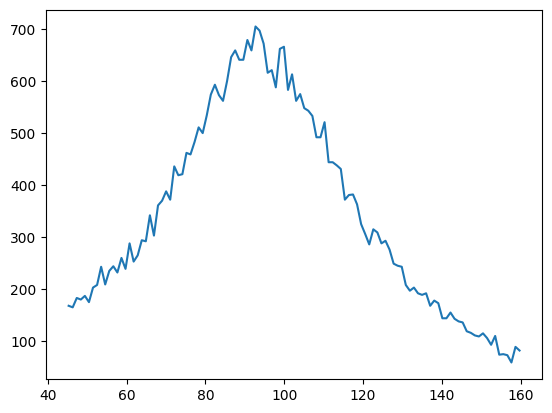

In [32]:
from lmfit.models import Model
import numpy as np
import pylandau

Datei_Name = "A4_V30.h5_charge.txt"
data = np.genfromtxt(Datei_Name, skip_header=0, skip_footer=0)
daten = np.histogram(data, bins=1000)
y = daten[0]

x = np.zeros(y.shape)
for i, x_wert in enumerate(daten[1]):
    if i == 0:
        continue
    x_pre_wert = daten[1][i-1]
    x[i-1] = (x_wert + x_pre_wert)/2
    
Daten.set_XName(r"Ladung [AU]")
Daten.set_YName(r"Anzahl")
Daten.set_FileName(Datei_Name)
Daten.set_x(x)
Daten.set_xerr(0)
Daten.set_y(y)
Daten.set_yerr(0)

# Mask definition
mask = (x > 45) & (x < 160)
plt.plot(x[mask],y[mask])

C:\Users\marie\AppData\Local\Temp\ipykernel_6592\1992557947.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return A * pylandau.langau(x, mpv, eta, sigma)


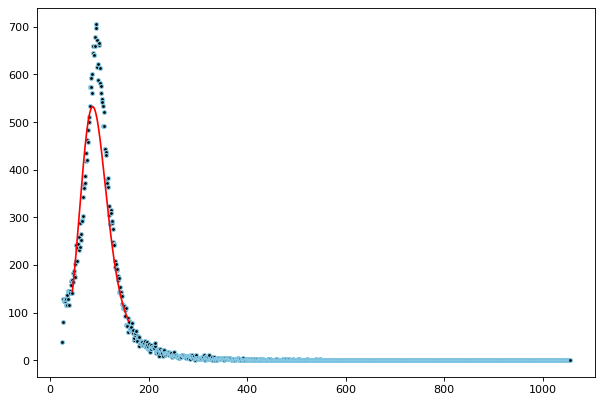

11.094462115213274


name,value,initial value,min,max,vary
mpv,102.500374,None,45.3036686,159.697079,True
eta,10.0000000,None,0.10000000,25.0000000,True
sigma,33.3187052,None,0.10000000,159.697079,True
A,705.000000,None,1.00000000,1410.00000,True


In [37]:


# Validate mask has data
x_masked = x[mask]
y_masked = y[mask]

if len(x_masked) == 0:
    raise ValueError("Mask results in empty dataset")

def land(x, mpv, eta, sigma, A):
    try:
        return A * pylandau.langau(x, mpv, eta, sigma)
    except Exception as e:
        print(f"Error in Landau function: {e}")
        return np.zeros_like(x)

mod = Model(land)
pars = mod.make_params()

# More robust initial parameter estimation
pars['mpv'].value = np.median(x_masked)
pars['mpv'].min = np.min(x_masked)
pars['mpv'].max = np.max(x_masked)

pars['eta'].value = 10
pars['eta'].min = 0.1
pars['eta'].max = 25.0

pars['sigma'].value = np.std(x_masked)
pars['sigma'].min = 0.1
pars['sigma'].max = np.max(x_masked)

pars['A'].value = np.max(y_masked)
pars['A'].min = 1
pars['A'].max = np.max(y_masked) * 2

# Add bounds and try different fitting method
weights = 1/np.sqrt(Daten.get_y()[mask])
weights[weights == np.inf] = 0
# Daten.set_yerr(weights)

result = mod.fit(y_masked, pars, x=x_masked, method='lbfgs', weights = weights)
result

finish(Daten.get_x(), Daten.get_y(), result, Daten.get_FileName(), 
       Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())
plt.show()
print(result.redchi)
pars

C:\Users\marie\AppData\Local\Temp\ipykernel_6592\3502189540.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return A * pylandau.langau(x, mpv, eta, sigma)


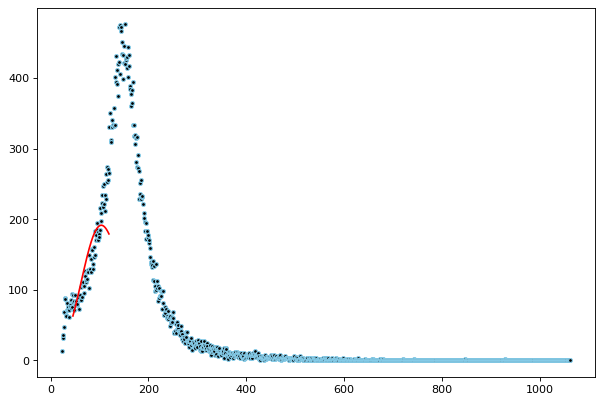

In [26]:
# Modify the finish function to handle potential data type issues
def finish(x, y, result, string, y_err, yLabel, xLabel, var_func_bool=False):
    # Ensure x is a numpy array
    x = np.asarray(x)
    
    # Create dynamic resolution array using the masked x
    dynamic_resolution_array = np.arange(x[mask].min(), x[mask].max(), 0.001*abs(x[mask].max() - x[mask].min()))
    
    fig = plt.figure(figsize=(9,6), dpi=80)
    plt.plot(dynamic_resolution_array, result.eval(x=dynamic_resolution_array), 'r-', 
             label=f'Fit: reduced $\chi^2$ = {to_precision(result.redchi, 3)}')
    plt.errorbar(
        y = Daten.get_y(), 
        x = Daten.get_x(), 
        yerr = 0,
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
        ) #xerr = x_err, yerr = y_err, 
    
    # Rest of your plotting code...
    
finish(Daten.get_x(), Daten.get_y(), result, Daten.get_FileName(), 
       Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())

C:\Users\marie\AppData\Local\Temp\ipykernel_6592\3502189540.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return A * pylandau.langau(x, mpv, eta, sigma)


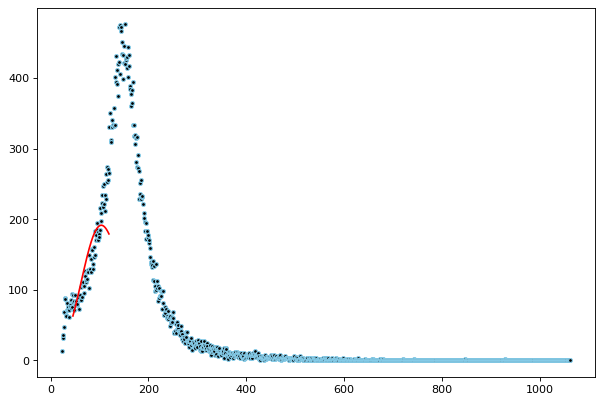

In [27]:
from lmfit.models import Model
import numpy as np
import pylandau

results = []
Voltages = [20, 30, 40, 50, 60, 70, 80]
Daten = Data()

for Volt in Voltages:
    Datei_Name = f"A4_V{Volt}.h5_charge.txt"
    data = np.genfromtxt(Datei_Name, skip_header=0, skip_footer=0)
    daten = np.histogram(data, bins=1000)
    y = daten[0]

    x = np.zeros(y.shape)
    for i, x_wert in enumerate(daten[1]):
        if i == 0:
            continue
        x_pre_wert = daten[1][i-1]
        x[i-1] = (x_wert + x_pre_wert)/2
        
    Daten.set_XName(r"Ladung [AU]")
    Daten.set_YName(r"Anzahl")
    Daten.set_FileName(Datei_Name)
    Daten.set_x(x)
    Daten.set_xerr(0)
    Daten.set_y(y)
    Daten.set_yerr(0)

    # Mask definition
    mask = (x > 45) & (x < 120)

    # Validate mask has data
    x_masked = x[mask]
    y_masked = y[mask]

    if len(x_masked) == 0:
        raise ValueError("Mask results in empty dataset")

    def land(x, mpv, eta, sigma, A):
        try:
            return A * pylandau.langau(x, mpv, eta, sigma)
        except Exception as e:
            print(f"Error in Landau function: {e}")
            return np.zeros_like(x)

    mod = Model(land)
    pars = mod.make_params()

    # More robust initial parameter estimation
    pars['mpv'].value = np.median(x_masked)
    pars['mpv'].min = np.min(x_masked)
    pars['mpv'].max = np.max(x_masked)

    pars['eta'].value = 10
    pars['eta'].min = 0.1
    pars['eta'].max = 25.0

    pars['sigma'].value = 60 #np.std(x_masked)
    pars['sigma'].min = 0.1
    pars['sigma'].max = np.max(x_masked)

    pars['A'].value = np.max(y_masked)
    pars['A'].min = 1
    pars['A'].max = np.max(y_masked) * 2

    # Add bounds and try different fitting method
    weights = 1/np.sqrt(Daten.get_y()[mask])
    weights[weights == np.inf] = 0
    # Daten.set_yerr(weights)

    result = mod.fit(y_masked, pars, x=x_masked, method='lbfgs', weights = weights)
    results.append(result)

finish(Daten.get_x(), Daten.get_y(), result, Daten.get_FileName(), 
       Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())
plt.show()

# finish(Daten.get_x(), Daten.get_y(), result, Daten.get_FileName(), 
#        Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())

In [21]:
for i in range(len(results)):
    print(results[i].redchi)

1.3154524478221652
304.8506275901926
502.53631818983337
14.258386831017255
332.0362266758067
271.108882650906
7.099546278525929


In [19]:
results[1]

In [ ]:
weights = 1/np.sqrt(Daten.get_y())
weights[weights == np.inf] = 0
Daten.set_yerr(weights)

result = mod.fit(Daten.get_y(), pars, x=Daten.get_x(), weights = weights)

In [ ]:
result

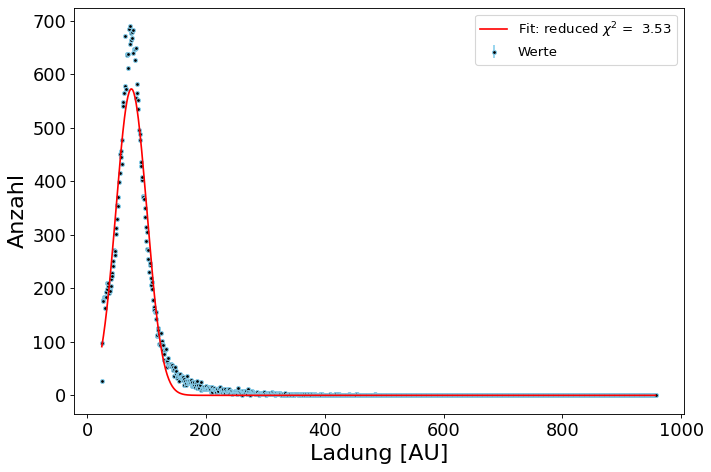

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/A4_V20.h5_charge.txt_Fit.pdf} 
	\caption{A4_V20.h5_charge.txt, Fit} 
 	\label{fig:A4_V20.h5_charge.txt, Fit} 
\end{figure}


TypeError: float() argument must be a string or a real number, not 'NoneType'

In [ ]:
x = Daten.get_x()
y = Daten.get_y()
y_err = Daten.get_yerr()
xLabel = Daten.get_YName()
yLabel = Daten.get_XName()
var_func_bool = False

fig = plt.figure(figsize=(9,6), dpi=80)
dynamic_resolution_array = np.arange(min(x),max(x), 0.001*abs(max(x)-min(x)))
#plt.plot(x, y, 'skyblue')
plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
plt.errorbar(
    y = y, 
    x = x, 
    yerr = y_err,
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, label = r'Werte'
    ) #xerr = x_err, yerr = y_err, 
plt.legend(loc='best')

plt.ylabel(yLabel, fontsize=20)
plt.xlabel(xLabel, fontsize=20)

plt.legend(fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
string = Daten.get_FileName()
string += Daten.get_Version()
fig.savefig(string + "_Fit.pdf")
plt.show()

string_fig = "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{Fits/" + string + "_Fit.pdf} \n" \
    + "\t\\caption{"+str(string)+", Fit} \n \t\\label{fig:"+str(string)+", Fit} \n\end{figure}"
print(string_fig)

text_file = open(string+"_params"+".tex", "w+", encoding="utf-8")
string_fig += "\n \\\\ \n" 
string_fig += get_Latex_Func(Daten.get_func()) if var_func_bool else ""
string_fig += table_of_params(result)
text_file.write(string_fig)
text_file.close()

In [17]:
pars

name,value,initial value,min,max,vary
amplitude,1.00000000,None,0.00000000,inf,True
mu_landau,10.0000000,None,-10.0000000,10.0000000,True
sigma_landau,1.00000000,None,0.10000000,10.0000000,True
mu_gauss,10.0000000,None,-10.0000000,10.0000000,True
sigma_gauss,1.00000000,None,0.10000000,10.0000000,True


## Non Interactive

In [27]:
Daten = Data()

import_Data(Datei="A2_Signal_110V_TimeProfile_130Latency", 
            x_err_bool = False, 
            y_err_bool = False, 
            x_name = "Zeit [ns]", y_name = "Mittleres Signal (ADC)", 
            Daten=Daten, 
            skip_lower = "0",
            skip_upper = "2",
            save_bool = False,
            Save=0, Load=0
            )

## Error Band

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{bilder/A2_Signal_110V_TimeProfile_130Latency_Messberreich.pdf} 
	\caption{A2_Signal_110V_TimeProfile_130Latency, Messberreich} 
 	\label{fig:A2_Signal_110V_TimeProfile_130Latency, Messberreich} 
\end{figure} 
 
 
\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{bilder/A2_Signal_110V_TimeProfile_132Latency_Messberreich.pdf} 
	\caption{A2_Signal_110V_TimeProfile_132Latency, Messberreich} 
 	\label{fig:A2_Signal_110V_TimeProfile_132Latency, Messberreich} 
\end{figure} 
 
 
\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{bilder/A2_Signal_110V_TimeProfile_133Latency_Messberreich.pdf} 
	\caption{A2_Signal_110V_TimeProfile_133Latency, Messberreich} 
 	\label{fig:A2_Signal_110V_TimeProfile_133Latency, Messberreich} 
\end{figure} 
 
 
\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{bilder/A2_Signal_110V_TimeProfile_134Latency_Messberr

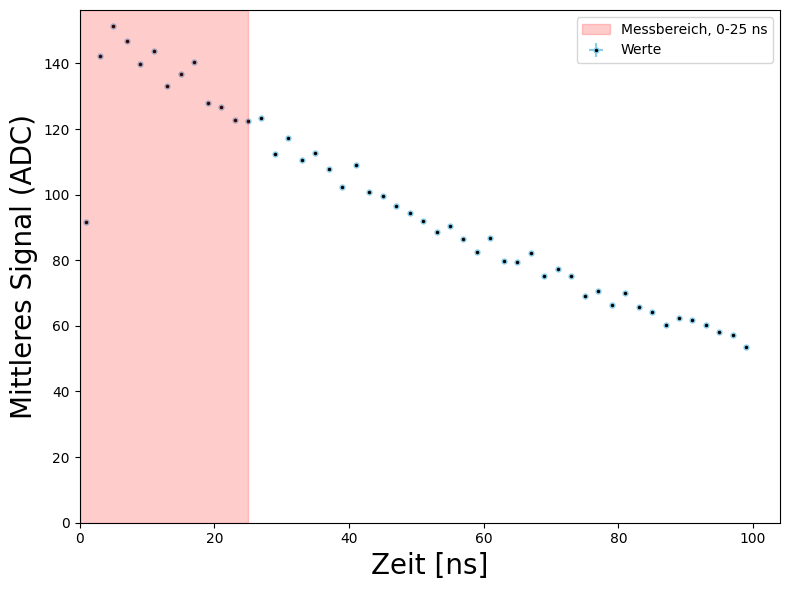

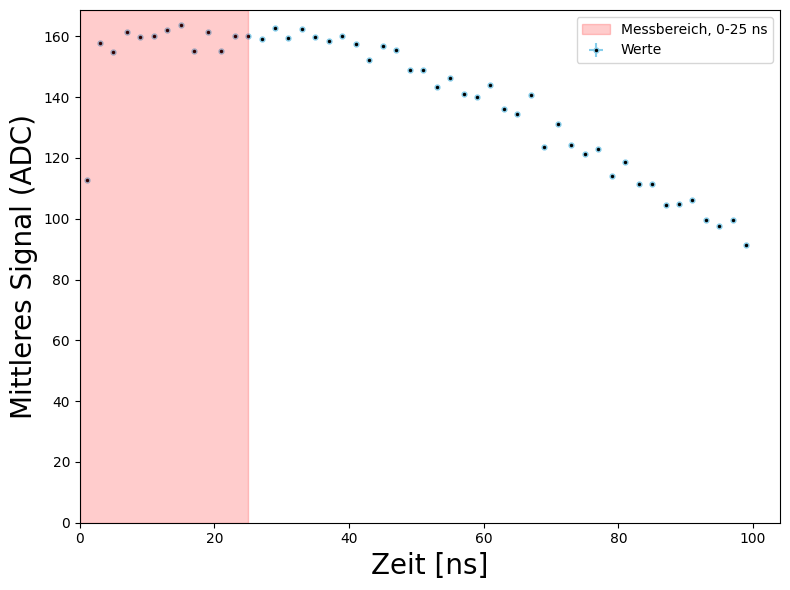

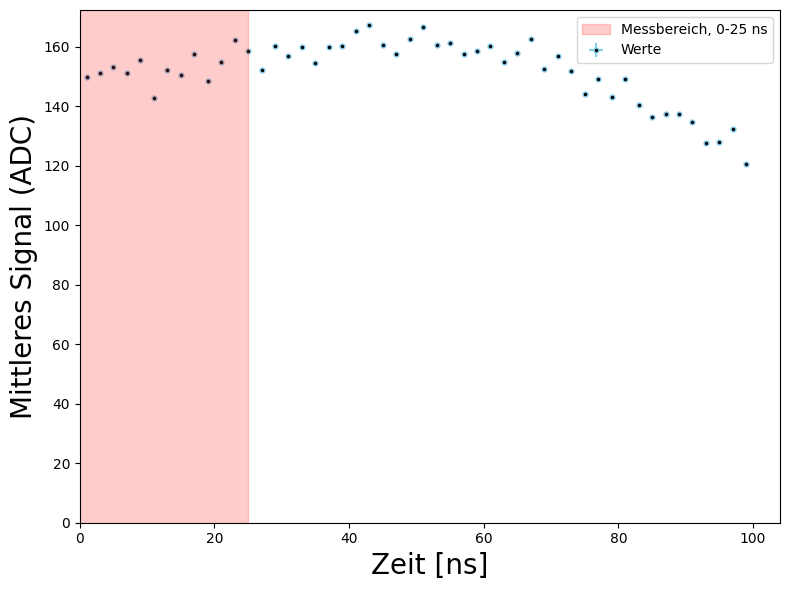

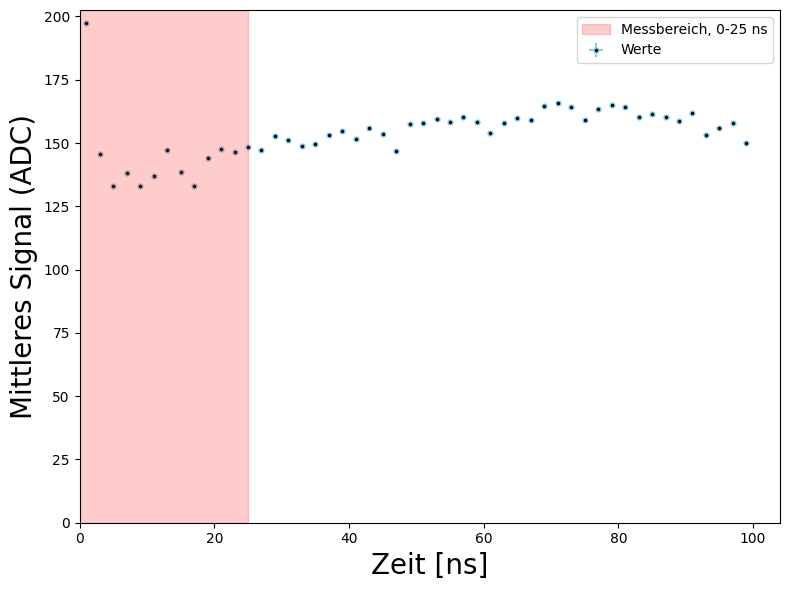

In [34]:
freq_lst = [130,132,133,134]
string_fig = ""
for freq in freq_lst:
    Daten = Data()

    import_Data(Datei=f"A2_Signal_110V_TimeProfile_{freq}Latency", 
            x_err_bool = False, 
            y_err_bool = False, 
            x_name = "Zeit [ns]", y_name = "Mittleres Signal (ADC)", 
            Daten=Daten, 
            skip_lower = "0",
            skip_upper = "2",
            save_bool = False,
            Save=0, Load=0, show_plot=False
            )

    x = Daten.get_x()
    string = Daten.get_FileName()

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.set_xlim([0, np.max(Daten.get_x())+5])
    ax.set_ylim([0, np.max(Daten.get_y())+5])
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')

    plt.fill_between(np.arange(0,26,1), 0, np.max(Daten.get_y())+5, alpha=0.2, color = "red", label = r'Messbereich, 0-25 ns')
    # plt.plot(x, y, label='Median with Error Band')
    #plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    # plt.title('Models')
    plt.tight_layout()
    string += Daten.get_Version()
    fig.savefig(string + "_Messberreich.pdf")

    string_fig += "\\begin{figure}[ht] \n \t\\centering \n \t\\includegraphics[width= 0.65 \\textwidth]{bilder/" + Daten.get_FileName() + "_Messberreich.pdf} \n" \
            + "\t\\caption{"+str(Daten.get_FileName())+", Messberreich} \n \t\\label{fig:"+str(Daten.get_FileName())+", Messberreich} \n\end{figure} \n \n \n"
        
print(string_fig)

## Fit-Funktionen festlegen

In [14]:
from sympy import oo, Symbol, integrate, Function
def convolve(f, g, t, lower_limit=-oo, upper_limit=oo):
    tau = Symbol('__very_unlikely_name__', real=True)
    return integrate(Function(f).subs(t, tau) * Function(g).subs(t, t - tau), 
                     (tau, lower_limit, upper_limit))

def Gauss(x,sigma=1,mu=1):
    return 1/(sigma*np.sqrt(2*math.pi))*np.exp(-1/2*(x-mu/sigma)**2)

def Landau(x):
    t = Symbol('__very_unlikely_name__', real=True)
    return integrate(1/(math.pi)*np.exp(-x*np.ln(t-x*t))*np.sin(math.pi*t) ,
                     (t, 0, oo))

def Model_test(x):
    return(convolve(Gauss, Landau, x))

In [10]:
from lmfit.models import PowerLawModel, ExponentialModel, GaussianModel, Model

# import pylandau

# def plot_func(x, mpv=1, eta=1, sigma=1, A=1):
#     return pylandau.langau(x, mpv, eta, sigma, A)

def plot_func(x, sigma = 1, nu = 1, amplitude=1):
    return amplitude/(sigma*np.sqrt(2*math.pi))*np.exp(-1/2*((x-nu)/sigma)**2)

Daten.set_func(plot_func)
mod = GaussianModel()

pars = mod.make_params()
pars

name,value,initial value,min,max,vary,expression
amplitude,1.00000000,None,-inf,inf,True,
center,0.00000000,None,-inf,inf,True,
sigma,1.00000000,None,0.00000000,inf,True,
fwhm,2.35482000,None,-inf,inf,False,2.3548200*sigma
height,0.39894230,None,-inf,inf,False,"0.3989423*amplitude/max(1e-15, sigma)"


## Parameter Festlegen

In [11]:
# Funktion zum Speichern der Parameter in einer JSON-Datei
def save_params_to_file(params, filename='params.json'):
    # Dictionary für Parameter-Werte erstellen
    params_dict = {name: param.value for name, param in params.items()}
    
    # Parameter als JSON-Datei speichern
    with open(filename, 'w') as f:
        json.dump(params_dict, f)
    print(f"Parameter wurden in {filename} gespeichert.")

# Funktion zum Einlesen der Parameter aus einer JSON-Datei
def load_params_from_file(params, filename='params.json'):
    # JSON-Datei öffnen und die Werte lesen
    with open(filename, 'r') as f:
        params_dict = json.load(f)

    # Geladene Werte in die Parameter setzen
    for name, value in params_dict.items():
        if name in params:
            params[name].value = value
        else:
            print(f"Warnung: Parameter {name} existiert nicht im aktuellen Modell.")

    print(f"Parameter wurden aus {filename} geladen.")

def update_model(Save:int=0, Load:int=0, **params):
    # Setze die Werte der Parameter
    for name, value in params.items():
        pars[name].value = value
    if Save != 0:
        # Aufruf der Funktion zum Speichern
        save_params_to_file(pars, f'{Daten.get_FileName()}_params_{Save}.json')
        Daten.set_Version(Save)
    if Load != 0:
        load_params_from_file(pars, f'{Daten.get_FileName()}_params_{Load}.json')
        Daten.set_Version(Load)

    # Berechne Modell mit aktuellen Parametern
    x = Daten.get_x()
    x_fit = np.arange(x.min(), x.max(), (x.max() - x.min())/10000)
    y_fit = mod.eval(pars, x=x_fit)

    # Plotten der Daten und des Modells
    plt.figure(figsize=(8, 6))
    plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
        fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
        label = r'Werte')
    
    plt.plot(x_fit, y_fit, label="Modell", color='red')
    plt.legend()
    plt.ylabel(Daten.get_YName(), fontsize=20)
    plt.xlabel(Daten.get_XName(), fontsize=20)
    plt.title('Models')
    result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
    Daten.set_pars(result)
    dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))
    plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'b-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))
    plt.tight_layout()
    plt.show()
    

In [ ]:
param_widgets = {}
for param_name, param in pars.items():
    param_widgets[param_name] = IntText(value=param.value,
                                            step=0.1,
                                            description=param_name)

# Interaktive Anzeige mit automatisch generierten Slidern
interact(update_model, Save=IntText(value=0), Load=IntText(value=0), **param_widgets)
print()

interactive(children=(IntText(value=0, description='Save'), IntText(value=0, description='Load'), IntText(valu…

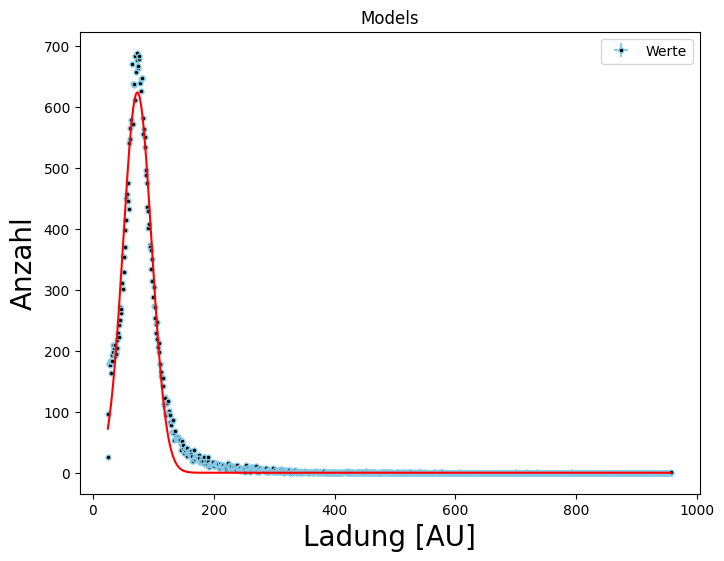

In [66]:
result = mod.fit(Daten.get_y(), pars, x=Daten.get_x())
dynamic_resolution_array = np.arange(min(Daten.get_x()),max(Daten.get_x()), 0.001*abs(max(Daten.get_x())-min(Daten.get_x())))

plt.figure(figsize=(8, 6))
plt.errorbar(y = Daten.get_y(), yerr = Daten.get_yerr(), x = Daten.get_x(), xerr = Daten.get_xerr(), \
    fmt = 'o', markersize = 3.5, alpha = 1, mfc = 'black', c = 'skyblue', zorder = 0, \
    label = r'Werte')

#plt.plot(x_fit, y_fit, label="Modell", color='red')
plt.legend()
plt.ylabel(Daten.get_YName(), fontsize=20)
plt.xlabel(Daten.get_XName(), fontsize=20)
plt.title('Models')

plt.plot(dynamic_resolution_array, result.eval(x = dynamic_resolution_array), 'r-', label = r'Fit: reduced $\chi^2$ =  '+str(to_precision(result.result.redchi,3)))

plt.show()

In [103]:
Daten.get_pars()

C:\Users\tlock\AppData\Local\Temp\ipykernel_18912\2553003439.py:1: RuntimeWarning: divide by zero encountered in divide
  weights = 1/np.sqrt(Daten.get_y())


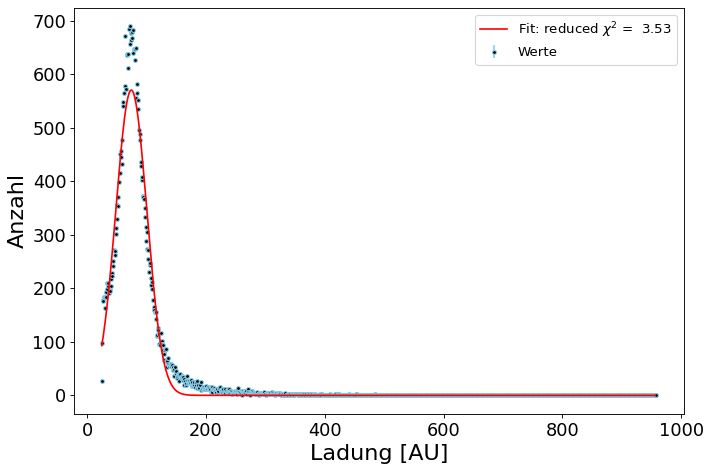

\begin{figure}[ht] 
 	\centering 
 	\includegraphics[width= 0.65 \textwidth]{Fits/A4_V20.h5_charge.txt_Fit.pdf} 
	\caption{A4_V20.h5_charge.txt, Fit} 
 	\label{fig:A4_V20.h5_charge.txt, Fit} 
\end{figure}


In [17]:
weights = 1/np.sqrt(Daten.get_y())
weights[weights == np.inf] = 0
Daten.set_yerr(weights)

result = mod.fit(Daten.get_y(), pars, x=Daten.get_x(), weights = weights)
finish(Daten.get_x(),Daten.get_y(),result, Daten.get_FileName(), Daten.get_yerr(), Daten.get_YName(), Daten.get_XName())